In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn.metrics import confusion_matrix

import essentia
essentia.log.warningActive = False   
#from essentia.standard import TensorflowPredictEffnetDiscogs, TensorflowPredictMusiCNN, TensorflowPredict2D
#import essentia.standard as es

from load_dataset import *   

In [2]:
df_features = load_features()
df_features[:3]

,path,genre,instrumental,voice,valence,arousal,bpm,key,scale,loudness,danceability
0,audio_chunks/audio.004/3k/3knBY7RDVHQIXYhPVxw5...,Hip Hop---Horrorcore,0.001786,0.998214,4.319933,5.401786,136.396011,"{'temperley': 'G', 'krumhansl': 'E', 'edma': 'E'}","{'temperley': 'major', 'krumhansl': 'minor', '...",-9.609755,1.427876
1,audio_chunks/audio.004/0D/0DvIRwRcYA62RUU1ohuE...,"Folk, World, & Country---Folk",0.028662,0.971338,3.910823,3.244471,123.713783,"{'temperley': 'Eb', 'krumhansl': 'Eb', 'edma':...","{'temperley': 'minor', 'krumhansl': 'minor', '...",-14.003602,0.956036
2,audio_chunks/audio.004/59/59yE5Hg5TSz86CoasCpD...,Rock---Power Metal,0.918112,0.081888,3.630838,6.089415,106.943352,"{'temperley': 'E', 'krumhansl': 'Ab', 'edma': ...","{'temperley': 'major', 'krumhansl': 'minor', '...",-8.263358,1.578111


In [ ]:
df_features['genre'].value_counts().to_csv('exports/all_genres.tsv', sep="\t") 

<Axes: xlabel='genre'>

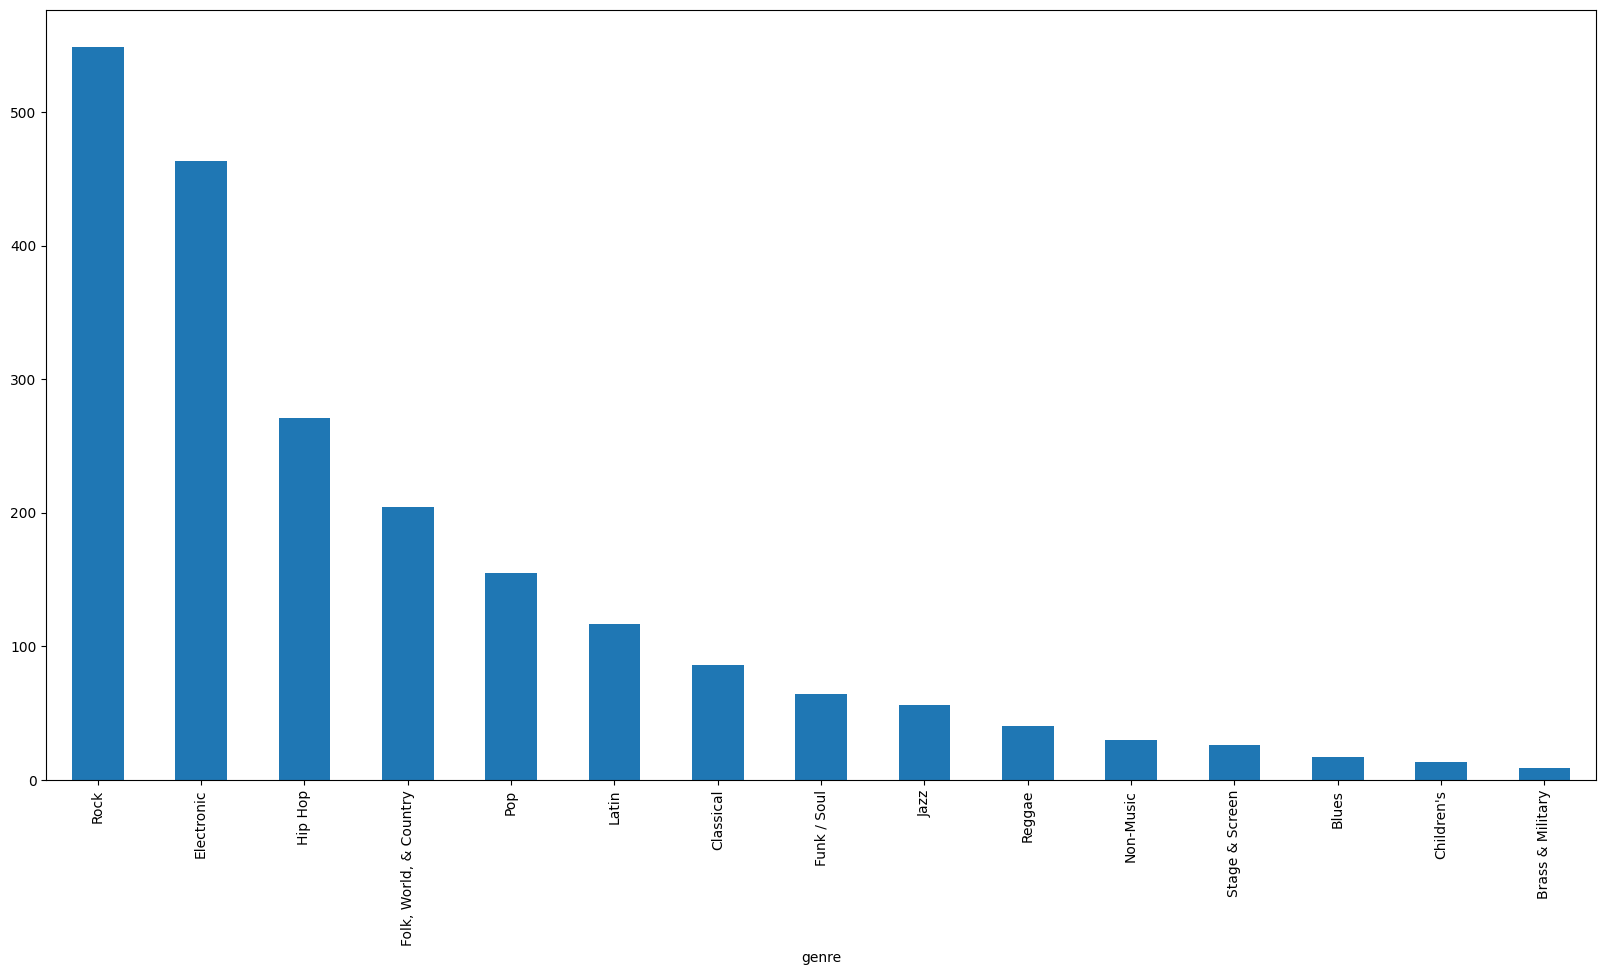

In [55]:
cleaned = df_features["genre"].str.split("---").str[0]
cleaned.value_counts().plot(kind='bar', figsize=(20,10))

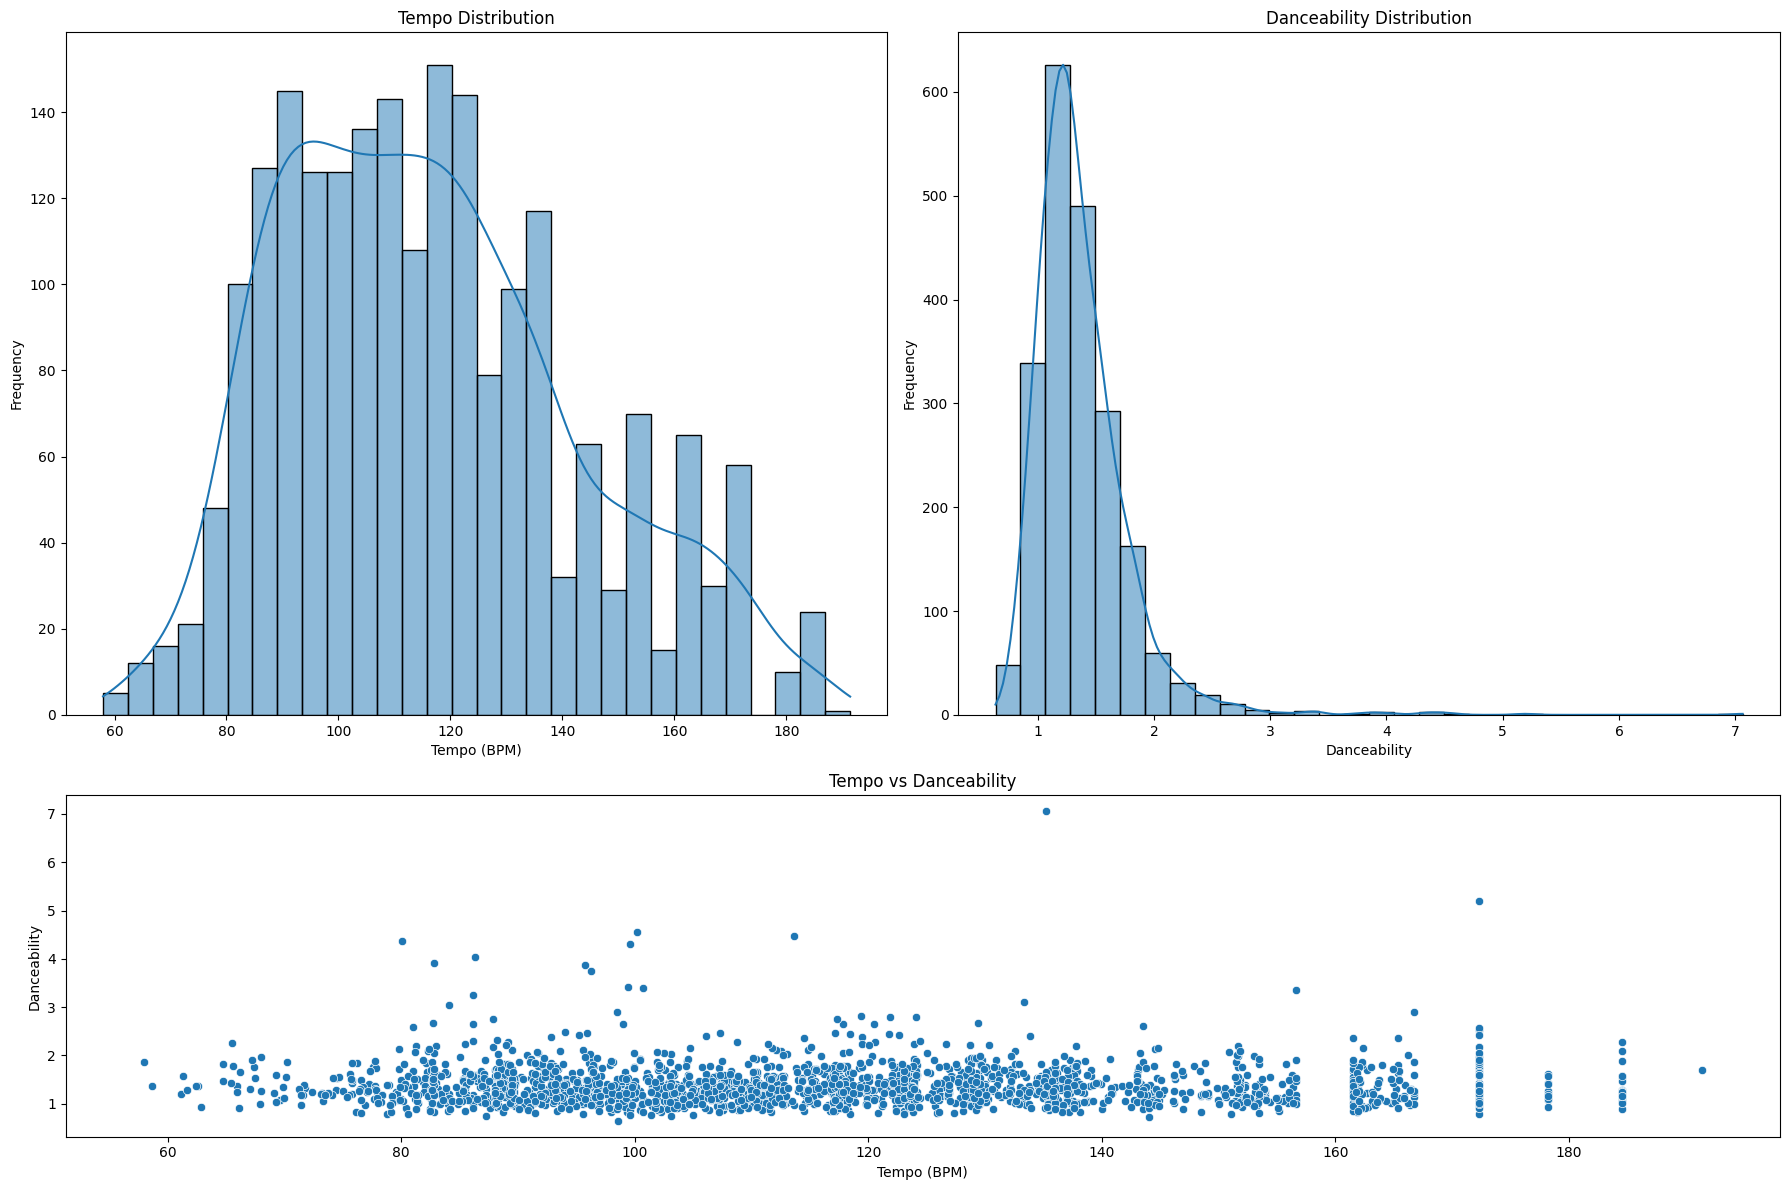

In [24]:
# Create a figure with a custom grid layout
fig = plt.figure(figsize=(18, 12))
gs = GridSpec(2, 2, height_ratios=[2, 1])

# Plotting the tempo distribution
ax0 = fig.add_subplot(gs[0, 0])
sns.histplot(df_features['bpm'], kde=True, bins=30, ax=ax0)
ax0.set_title('Tempo Distribution')
ax0.set_xlabel('Tempo (BPM)')
ax0.set_ylabel('Frequency')

# Plotting the danceability distribution
ax1 = fig.add_subplot(gs[0, 1])
sns.histplot(df_features['danceability'], kde=True, bins=30, ax=ax1)
ax1.set_title('Danceability Distribution')
ax1.set_xlabel('Danceability')
ax1.set_ylabel('Frequency')

# Plotting the 2D scatter plot for tempo and danceability
ax2 = fig.add_subplot(gs[1, :])
sns.scatterplot(x='bpm', y='danceability', data=df_features, ax=ax2)
ax2.set_title('Tempo vs Danceability')
ax2.set_xlabel('Tempo (BPM)')
ax2.set_ylabel('Danceability')

# Adjust layout
plt.tight_layout()
plt.show()

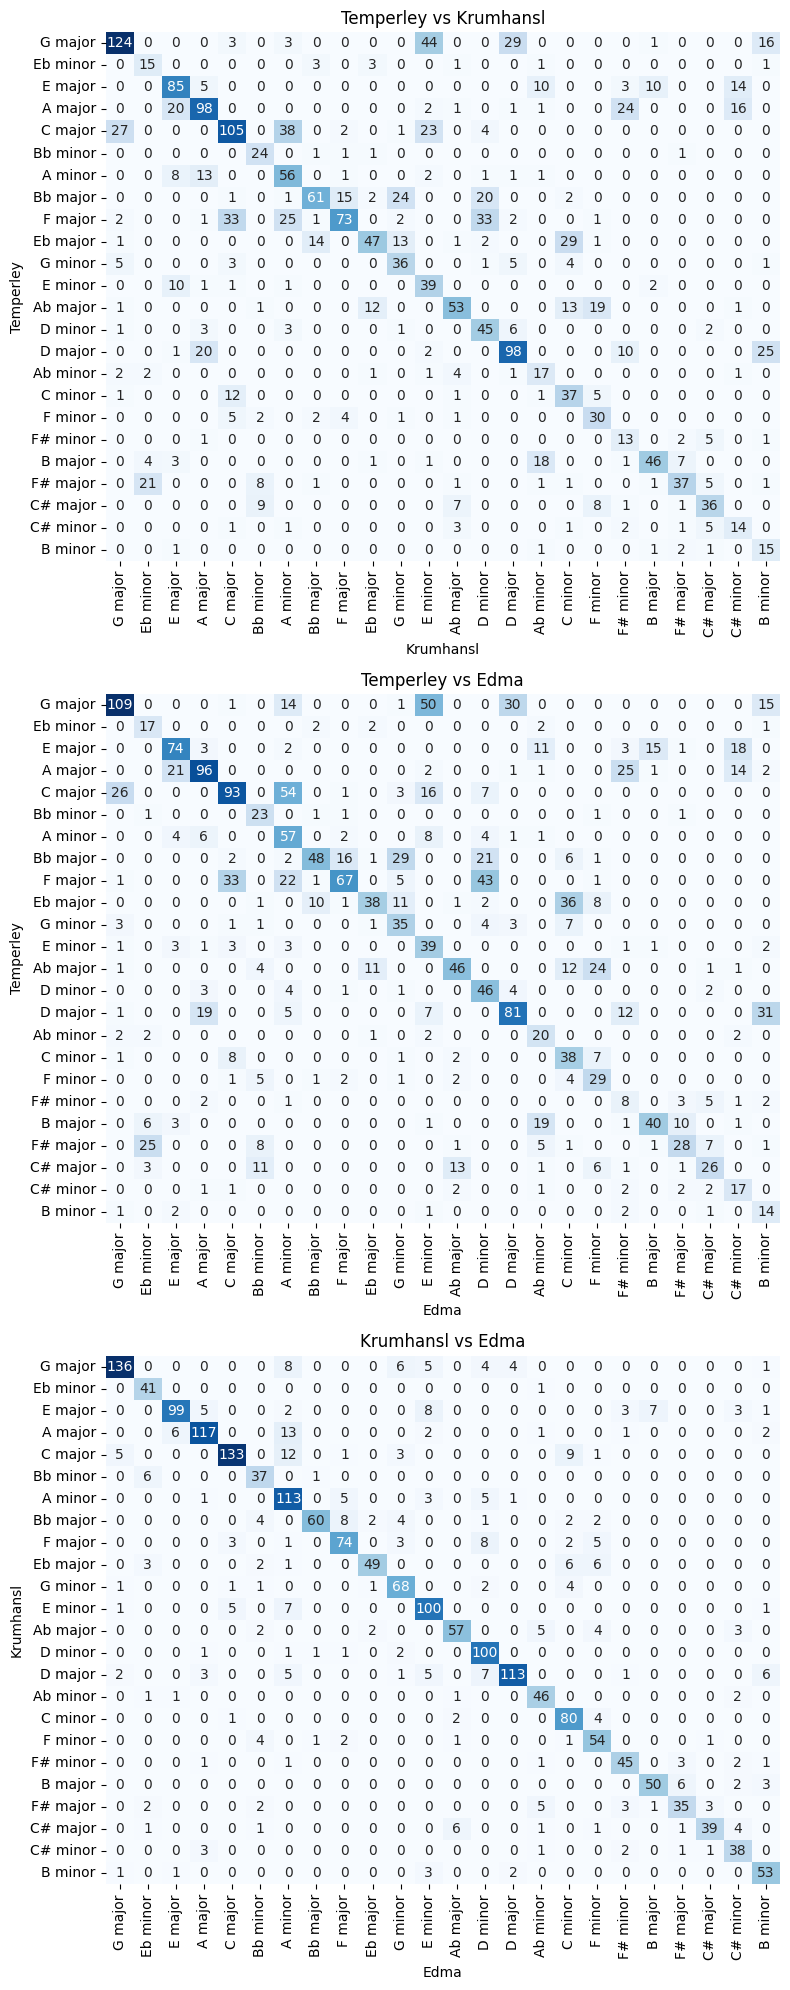

In [ ]:
key_models = ['temperley', 'krumhansl', 'edma']

# Extract key and scale predictions for each model
df_keys_temperley = pd.DataFrame(df_features['key'].to_list())[key_models[0]]
df_scales_temperley = pd.DataFrame(df_features['scale'].to_list())[key_models[0]]
df_keys_scales_temperley = df_keys_temperley + ' ' + df_scales_temperley

df_keys_krumhansl = pd.DataFrame(df_features['key'].to_list())[key_models[1]]
df_scales_krumhansl = pd.DataFrame(df_features['scale'].to_list())[key_models[1]]
df_keys_scales_krumhansl = df_keys_krumhansl + ' ' + df_scales_krumhansl

df_keys_edma = pd.DataFrame(df_features['key'].to_list())[key_models[2]]
df_scales_edma = pd.DataFrame(df_features['scale'].to_list())[key_models[2]]
df_keys_scales_edma = df_keys_edma + ' ' + df_scales_edma

# Combine the predictions into a single DataFrame
df_keys_scales_combined = pd.DataFrame({
    'temperley': df_keys_scales_temperley,
    'krumhansl': df_keys_scales_krumhansl,
    'edma': df_keys_scales_edma
})

# Function to plot confusion matrix
def plot_confusion_matrix(ax, y_true, y_pred, true_label, pred_label):
    cm = confusion_matrix(y_true, y_pred, labels=df_keys_scales_combined['temperley'].unique())
    cm_df = pd.DataFrame(cm, index=df_keys_scales_combined['temperley'].unique(), columns=df_keys_scales_combined['temperley'].unique())
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f'{true_label} vs {pred_label}')
    ax.set_xlabel(pred_label)
    ax.set_ylabel(true_label)

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 20))

# Plot confusion matrices for each pair of models
plot_confusion_matrix(axes[0], df_keys_scales_combined['temperley'], df_keys_scales_combined['krumhansl'], 'Temperley', 'Krumhansl')
plot_confusion_matrix(axes[1], df_keys_scales_combined['temperley'], df_keys_scales_combined['edma'], 'Temperley', 'Edma')
plot_confusion_matrix(axes[2], df_keys_scales_combined['krumhansl'], df_keys_scales_combined['edma'], 'Krumhansl', 'Edma')

# Adjust layout
plt.tight_layout()
plt.show()

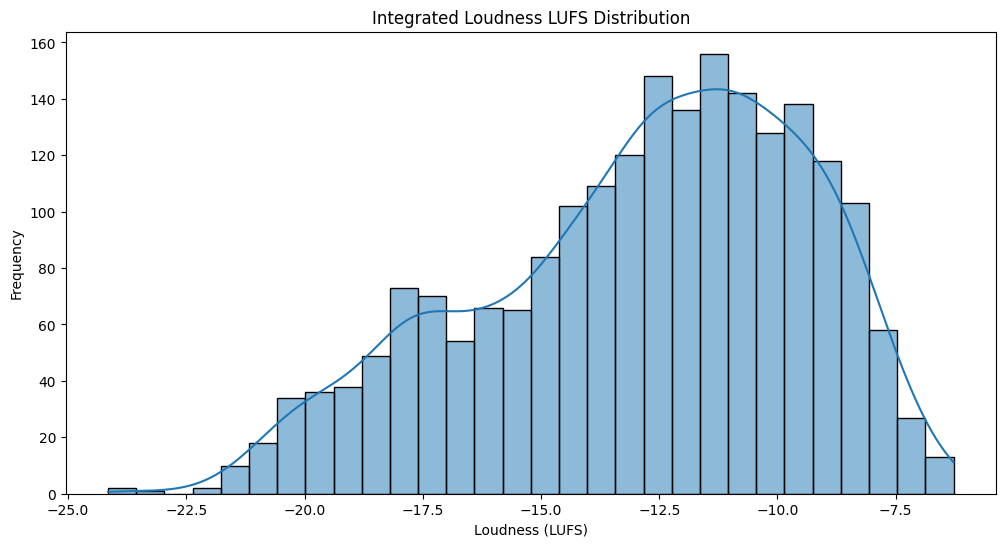

In [52]:
# Plotting the integrated loudness LUFS distribution
plt.figure(figsize=(12, 6))
sns.histplot(df_features['loudness'], kde=True, bins=30)
plt.title('Integrated Loudness LUFS Distribution')
plt.xlabel('Loudness (LUFS)')
plt.ylabel('Frequency')
plt.show()

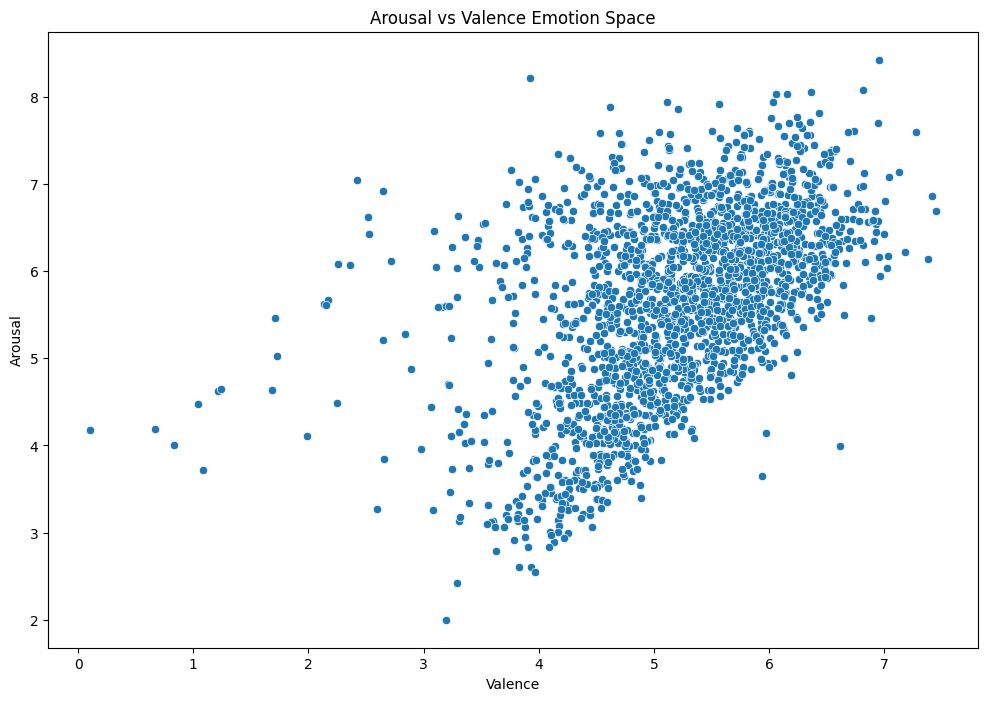

In [53]:
# Plotting the 2D distribution of arousal and valence
plt.figure(figsize=(12, 8))
sns.scatterplot(x='valence', y='arousal', data=df_features)
plt.title('Arousal vs Valence Emotion Space')
plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.show()

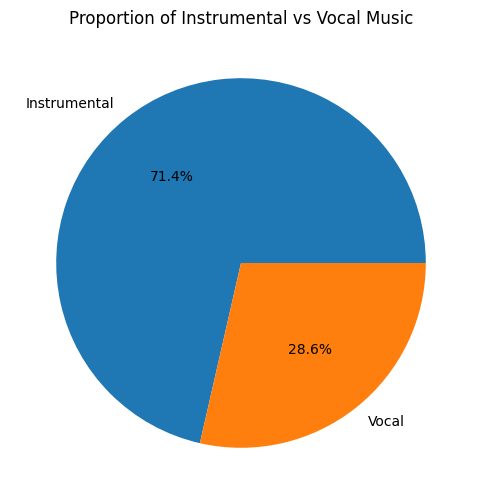

In [76]:
df_features['is_it_instrumental'] = df_features['instrumental'] > 0.5

# Calculate the proportion of each category
proportions = df_features['is_it_instrumental'].value_counts(normalize=True)

# Plotting the distribution of instrumental vs non-instrumental music as a pie chart
plt.figure(figsize=(6, 6))
proportions.plot.pie(labels=['Instrumental', 'Vocal'], autopct='%1.1f%%')
plt.title('Proportion of Instrumental vs Vocal Music')
plt.ylabel('')
plt.show()

AttributeError: Rectangle.set() got an unexpected keyword argument 'stacked'

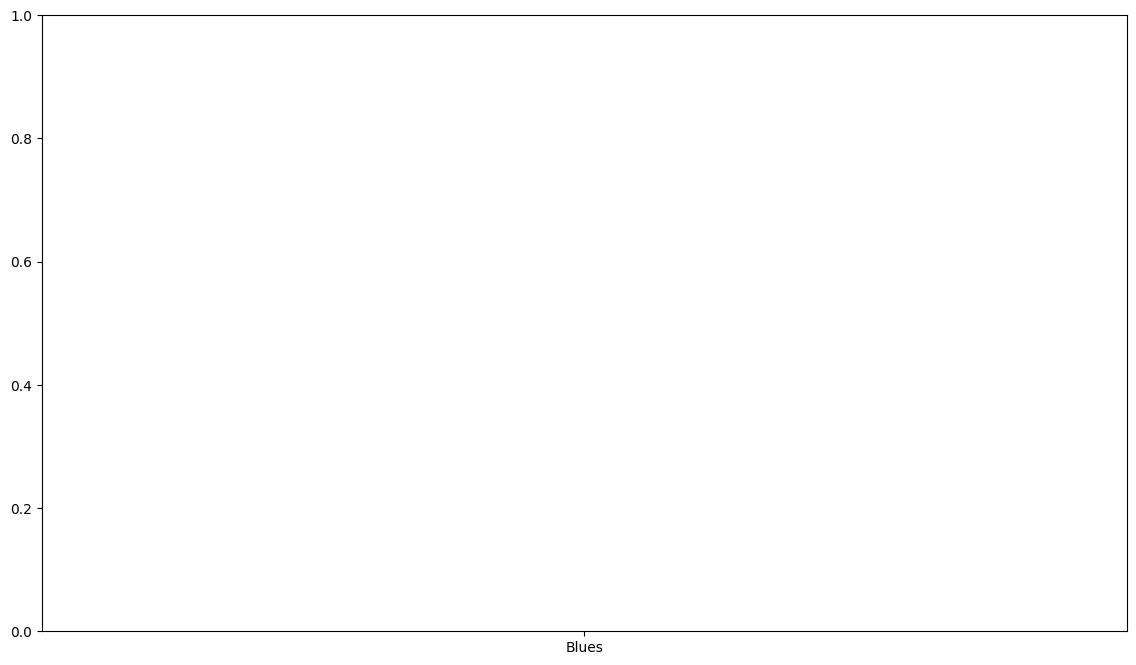

In [ ]:
# Add the 'instrumental' and 'voice' columns
df_features['is_it_instrumental'] = df_features['instrumental'] > 0.5

# Remove the text after '---' in the 'genre' column
df_features['genre_group'] = df_features['genre'].str.split('---').str[0]

# Group by 'is_it_instrumental' and 'genre_group' and count the occurrences
genre_counts = df_features.groupby(['is_it_instrumental', 'genre_group']).size().reset_index(name='count')

# Calculate the total count for each genre group
total_counts = genre_counts.groupby('genre_group')['count'].sum().reset_index(name='total_count')

# Merge the total counts with the genre counts
genre_counts = genre_counts.merge(total_counts, on='genre_group')

# Calculate the proportion of each category within each genre group
genre_counts['proportion'] = genre_counts['count'] / genre_counts['total_count']

# Plotting the distribution of genres based on whether the music is instrumental or not
plt.figure(figsize=(14, 8))
sns.barplot(x='genre_group', y='proportion', hue='is_it_instrumental', data=genre_counts)
plt.title('Genre Distribution Based on Instrumental vs Vocal Music (Proportions)')
plt.xlabel('Genre Group')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(labels=['Vocal', 'Instrumental'])
plt.ylim(0, 1)
plt.show()

<Figure size 1400x800 with 0 Axes>

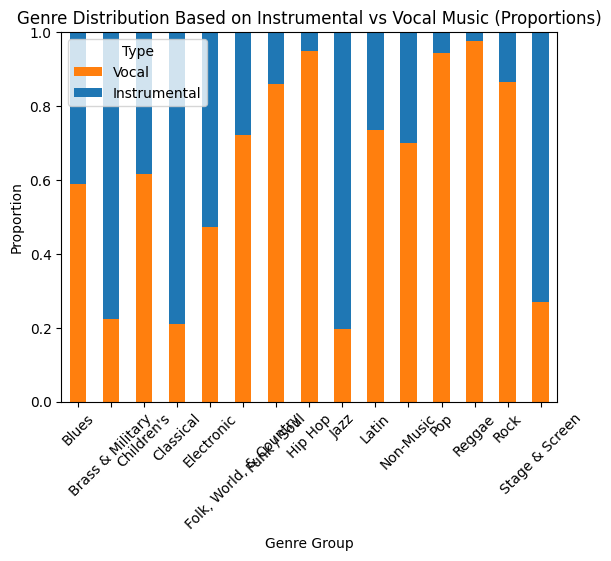

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_features is already loaded with your data and contains 'instrumental' and 'genre' columns

# Add the 'is_it_instrumental' column
df_features['is_it_instrumental'] = df_features['instrumental'] > 0.5

# Remove the text after '---' in the 'genre' column
df_features['genre_group'] = df_features['genre'].str.split('---').str[0]

# Group by 'is_it_instrumental' and 'genre_group' and count the occurrences
genre_counts = df_features.groupby(['is_it_instrumental', 'genre_group']).size().reset_index(name='count')

# Calculate the total count for each genre group
total_counts = genre_counts.groupby('genre_group')['count'].sum().reset_index(name='total_count')

# Merge the total counts with the genre counts
genre_counts = genre_counts.merge(total_counts, on='genre_group')

# Calculate the proportion of each category within each genre group
genre_counts['proportion'] = genre_counts['count'] / genre_counts['total_count']

# Pivot the data to get the proportions in separate columns for stacking
pivot_df = genre_counts.pivot(index='genre_group', columns='is_it_instrumental', values='proportion').fillna(0)

# Plotting the stacked bar plot
pivot_df.plot(kind='bar', stacked=True, color=['#ff7f0e', '#1f77b4'], figsize=(14, 8))
plt.title('Genre Distribution Based on Instrumental vs Vocal Music (Proportions)')
plt.xlabel('Genre Group')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(labels=['Vocal', 'Instrumental'], title='Type')
plt.ylim(0, 1)
plt.show()

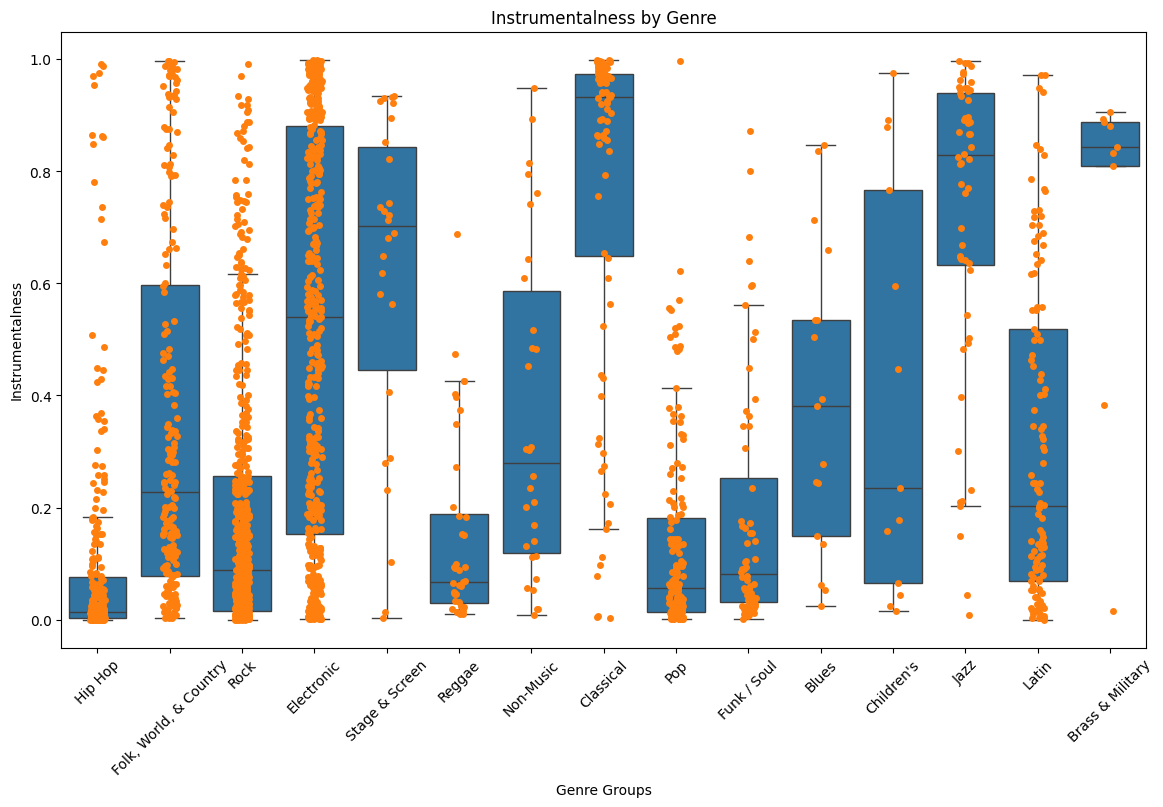

In [ ]:
df_features['genre_group'] = df_features['genre'].str.split('---').str[0]

# Plotting the box plot with scatter plot overlay
plt.figure(figsize=(14, 8))
sns.boxplot(x='genre_group', y='instrumental', data=df_features, whis=1.5, fliersize=0)  # Box plot
sns.stripplot(x='genre_group', y='instrumental', data=df_features)  # Scatter plot
plt.title('Instrumentalness by Genre')
plt.xlabel('Genre Groups')
plt.ylabel('Instrumentalness')
plt.xticks(rotation=45)
plt.show()